<a href="https://colab.research.google.com/github/andrewjonathanbs/NetworkPharmacology-ParemRematik/blob/main/Network_Pharmacology_of_Param_Rematik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install rdkit
!pip install pubchempy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=2fdc60fd5bc8e3a5163498d5828a022fbc90b069aa72bd03a9083124ab4f9dee
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
st = StandardScaler()
import matplotlib.pyplot as plt
import pubchempy as pcp
import seaborn as sns
import time
from rdkit.Chem import Crippen, rdMolDescriptors, Lipinski
from pubchempy import get_compounds, Compound

In [ ]:
import csv

# Path to your input and output files
input_file = '/content/drive/MyDrive/Network Pharmacology of Tawar/DrugBank.txt'
output_file = '/content/drive/MyDrive/Network Pharmacology of Tawar/output.csv'

# Open input and output files
with open(input_file, 'r') as txt_file, open(output_file, 'w', newline='') as csv_file:
    # Define a CSV writer
    csv_writer = csv.writer(csv_file)

    # Read each line from the TXT file
    for line in txt_file:
        # Split the line by spaces
        data = line.strip().split()

        # Write the split data into the CSV file
        csv_writer.writerow(data)

print("Conversion completed successfully.")

Conversion completed successfully.


In [ ]:
df_drug = pd.read_csv('/content/drive/MyDrive/Network Pharmacology of Tawar/output.csv')
df_drug.head()

,ID,CHECK,SMILES,ANEH,GU
0,DB00303,P45059,[H][C@]12[C@@H](C)C(S[C@]3([H])CN[C@@]([H])(C3...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,1
1,DB00114,P19113,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1
2,DB00117,P19113,N[C@@H](CC1=CNC=N1)C(O)=O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1
3,DB00142,Q9UI32,N[C@@H](CCC(O)=O)C(O)=O,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,1
4,DB01839,P00488,CC(O)CO,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,1


In [ ]:
df_drug.to_csv('/content/drive/MyDrive/Network Pharmacology of Tawar/df_drugbank.csv')

In [ ]:
smiles = df_drug['SMILES'].tolist()
print(len(smiles))

35022


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

def tanimoto(smiles1, smiles2):
    # Convert SMILES strings to RDKit molecule objects
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    # Generate Morgan fingerprints for the molecules
    fp1 = AllChem.GetMorganFingerprint(mol1, 2)  # radius 2 Morgan fingerprint
    fp2 = AllChem.GetMorganFingerprint(mol2, 2)  # radius 2 Morgan fingerprint

    # Calculate Tanimoto similarity between the fingerprints
    similarity = TanimotoSimilarity(fp1, fp2)

    return similarity

In [ ]:
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors

def calculate_logkp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    log_p = Crippen.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    log_kp = -6.136 + 0.818*log_p - 0.005*tpsa - 0.007*mw
    return log_kp

In [ ]:
def read_file_lines(file_path):
    # Initialize an empty list to store the lines
    lines = []

    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Strip newline characters and append the line to the list
            lines.append(line.strip())

    return lines

In [ ]:
def veber_rule(molecule):
    """
    Apply Veber's Rule to evaluate the molecule's drug-likeness.

    Args:
    molecule (RDKit Mol object): The molecule to evaluate.

    Returns:
    bool: True if the molecule passes Veber's Rule, False otherwise.
    """
    num_rotatable_bonds = rdMolDescriptors.CalcNumRotatableBonds(molecule)
    polar_surface_area = rdMolDescriptors.CalcTPSA(molecule)

    return num_rotatable_bonds <= 10 and polar_surface_area <= 140

def egan_rule(molecule):
    """
    Apply Egan's Rule to evaluate the molecule's drug-likeness.

    Args:
    molecule (RDKit Mol object): The molecule to evaluate.

    Returns:
    bool: True if the molecule passes Egan's Rule, False otherwise.
    """
    logP = Crippen.MolLogP(molecule)
    molecular_weight = rdMolDescriptors.CalcExactMolWt(molecule)

    return 1 <= logP <= 3.5 and molecular_weight <= 400

def lipinski_rule_of_five(molecule_smiles):
    """
    Perform Lipinski's Rule of Five screening for a molecule.

    Args:
    molecule_smiles (str): SMILES representation of the molecule.

    Returns:
    bool: True if the molecule passes Lipinski's Rule of Five, False otherwise.
    """
    # Convert SMILES to RDKit molecule object
    molecule = Chem.MolFromSmiles(molecule_smiles)

    # Check if molecule is None (invalid SMILES)
    if molecule is None:
        raise ValueError("Invalid SMILES representation")

    # Apply Lipinski's Rule of Five
    violations = 0
    if Lipinski.NumHDonors(molecule) > 5:
        violations += 1
    if Lipinski.NumHAcceptors(molecule) > 10:
        violations += 1
    if Chem.CalcNumRotatableBonds(molecule) > 10:
        violations += 1
    if Chem.CalcExactMolWt(molecule) > 500:
        violations += 1

    # Return True if violations are less than or equal to 1
    return violations <= 1

In [ ]:
# Example usage
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Oryza.txt'  # Replace 'example.txt' with the path to your text file
np_oryzas = read_file_lines(file_path)
print(np_oryzas)

['Coronatine', 'ent-Kaurene', 'delta-Tocopherol', 'beta-Tocopherol', 'gamma-Tocopherol', 'alpha-Tocopherol', '(+)-Dehydrovomifoliol', 'Phytocassane B', 'Phytocassane C', 'Phytocassane D', 'Phytocassane E', 'alpha-Tocotrienol', 'beta-Tocotrienol', 'delta-Tocotrienol', 'gamma-Tocotrienol', 'Phytocassane A', '1-Butyl-2-propylcyclopentane', '2,2,6-Trimethyldecane', '2,6-Dimethyl-decahydronaphthalene', '2-Hexyl-1-decanol', '2-methylhexane', '4,6-Dimethylundecane', '28-Homotyphasterol']


In [ ]:
np_oryza = []
broken_oryza = []
names_o = []

In [ ]:
for x in np_oryzas:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_oryza.append(compo)
            names_o.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_oryzas.index(x)))
    broken_oryza.append(np_oryzas.index(x))

Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 22


In [ ]:
print(np_oryza)

['CC[C@@H]1C[C@H]2[C@H](CCC2=O)C(=C1)C(=O)N[C@]3(C[C@@H]3CC)C(=O)O', 'C[C@@]12CCCC([C@H]1CC[C@]34[C@H]2CC[C@H](C3)C(=C)C4)(C)C', 'CC1=CC(=O)CC([C@]1(/C=C/C(=O)C)O)(C)C', 'C[C@@H]1[C@@H]2CC[C@@H]3[C@@]([C@H]2C(=O)C=C1C=C)([C@@H]([C@@H]([C@@H](C3(C)C)O)O)O)C', 'C[C@@H]1[C@@H]2CC[C@@H]3[C@@]([C@H]2C(=O)C=C1C=C)([C@@H](C[C@@H](C3(C)C)O)O)C', 'C[C@H]1[C@H]2CC[C@H]3[C@]([C@@H]2C(=O)C=C1C=C)(CC(=O)[C@H](C3(C)C)O)C', 'C[C@@H]1[C@@H]2CC[C@@H]3[C@@]([C@H]2C(=O)C=C1C=C)([C@@H](CC(=O)C3(C)C)O)C', 'CC1=CC(=CC2=C1O[C@](CC2)(C)CC/C=C(\\C)/CC/C=C(\\C)/CCC=C(C)C)O', 'C[C@H]1[C@H]2CC[C@H]3[C@]([C@@H]2C(=O)C=C1C=C)(C[C@H](C(=O)C3(C)C)O)C', 'CCCCC1CCCC1CCC', 'CCCCC(C)CCCC(C)(C)C', 'CC1CCC2CC(CCC2C1)C', 'CCCCC(C)C', 'CCCCCC(C)CC(C)CCC']


In [ ]:
print(names_o)

['Coronatine', 'ent-Kaurene', '(+)-Dehydrovomifoliol', 'Phytocassane B', 'Phytocassane C', 'Phytocassane D', 'Phytocassane E', 'delta-Tocotrienol', 'Phytocassane A', '1-Butyl-2-propylcyclopentane', '2,2,6-Trimethyldecane', '2,6-Dimethyl-decahydronaphthalene', '2-methylhexane', '4,6-Dimethylundecane']


In [ ]:
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Zingiber.txt'  # Replace 'example.txt' with the path to your text file
np_Zingibers = read_file_lines(file_path)
np_Zingiber = []
names_z = []
broken_Zingiber = []
for x in np_Zingibers:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_Zingiber.append(compo)
            names_z.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_Zingibers.index(x)))
    broken_Zingiber.append(np_Zingibers.index(x))

Nope!
Nope!
Nope!
Nope!
Name error: 14
Nope!
Nope!
Name error: 17
Name error: 18
Name error: 19
Nope!
Name error: 21
Name error: 22
Name error: 23
Name error: 24


In [ ]:
print(np_Zingiber)

['C[C@]12CC[C@H](C1(C)C)CC2=O', 'CC1=CCC2CC1C2(C)C', 'CC1(C2CCC(=C)C1C2)C', 'CC1(C2CCC(C2)C1=C)C', 'CC(=CCC/C(=C/C=O)/C)C', 'C[C@@H]1CC[C@@H]2[C@]13CC=C([C@H](C3)C2(C)C)C', 'CC(=CCC/C(=C/C/C=C(\\C)/C=C)/C)C', 'C/C/1=C\\CCC(=C)/C=C/[C@@H](CC1)C(C)C', 'CC(C)C1CCC2(C3C1C4C2(C4C3)C)C', 'CCCCCCCCCC(=O)C']


In [ ]:
print(names_z)

['(-)-Camphor', 'alpha-Pinene', 'beta-Pinene', 'Camphene', 'trans-Citral', 'alpha-Cedrene', 'alpha-Farnesene', '(-)-Germacrene D', '(+)-Cyclosativene', '2-Undecanone']


In [ ]:
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Piper.txt'  # Replace 'example.txt' with the path to your text file
np_Pipers = read_file_lines(file_path)
np_Piper = []
names_p = []
broken_Piper = []
for x in np_Pipers:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_Piper.append(compo)
            names_p.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_Pipers.index(x)))
    broken_Piper.append(np_Pipers.index(x))

Nope!
Name error: 3
Name error: 5
Nope!
Nope!


In [ ]:
print(np_Piper)

['CC[C@H](CC[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)C(C)C', 'CC[C@H](/C=C/[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C)C(C)C', 'CCCCC/C=C\\C=C\\C(=O)NCC(C)C', 'CCCCC/C=C/C=C/C(=O)N1CCCC1', 'CCCCCCC/C=C/C=C/C(=O)N1CCCC1', 'CC[C@H](CC[C@@H](C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC[C@@H]4[C@@]3(CC[C@@H](C4)O)C)C)C(C)C']


In [ ]:
print(names_p)

['(-)-beta-Sitosterol', 'beta-Stigmasterol', 'N-Isobutyldeca-trans-2-trans-4-dienamide', 'Sarmentine', '[(2E,4E)-Dodecadienoyl]-pyrrolidine', '(3beta,5alpha)-Stigmastan-3-ol']


In [ ]:
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Sativa.txt'  # Replace 'example.txt' with the path to your text file
np_Sativas = read_file_lines(file_path)
np_Sativa = []
names_s = []
broken_Sativa = []
for x in np_Sativas:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_Sativa.append(compo)
            names_s.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_Sativas.index(x)))
    broken_Sativa.append(np_Sativas.index(x))

Name error: 1
Name error: 2
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 26
Nope!
Nope!
Nope!
Name error: 32
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 73
Nope!
Nope!
Name error: 85
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 97
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 107
Name error: 108
Name error: 109


In [ ]:
print(np_Sativa)

['C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O', 'C1=CC(=CC=C1C(=O)O)O', 'C1=CC(=C(C=C1C(=O)O)O)O', 'COC1=C(C=C(C=C1)C(=O)O)OC', 'C1=CC(=CC(=C1)O)/C=C/C(=O)O', 'CSS/C=C/CS(=O)C', 'C=CCSSC[C@@H](C(=O)O)N', 'C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2', 'C1=CC=C(C(=C1)/C=C/C(=O)O)O', 'C1=CC(=C(C=C1O)O)C(=O)O', 'CCCSS(=O)CC=C', 'CC1=CC(=CS1)C', 'CC1(C2CCC(O1)(CC2)C)C', 'CC(=CCC/C(=C/C(OC)OC)/C)C', 'CCCS(=O)SCC=C', 'C1=CC(=CC=C1/C=C/C(=O)O)O', 'C1=CC(=C(C=C1/C=C/C(=O)O)O)O', 'CC1=CCC2CC1C2(C)C', 'CC1=CCC(CC1)C(=C)C', 'CC(=CCC/C(=C/CO)/C)C', 'C1[C@@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O', 'C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O', 'C1[C@H](OC2=CC(=CC(=C2C1=O)O)O)C3=CC=C(C=C3)O', 'C=CCSS(=O)CC=C', 'CCCSSCCC', 'CSSCC=C', 'C=CCS(=O)C[C@@H](C(=O)O)N', 'COC1=CC=C(C=C1)C2=COC3=CC(=CC(=C3C2=O)O)O', 'COC1=CC=C(C=C1)C2=COC3=C(C2=O)C=CC(=C3)O', 'C1=C(C=C(C(=C1O)O)O)C(=O)O', 'C1=CC(=C(C=C1O)C(=O)O)O', 'C1=CC(=C(C(=C1)O)O)O', 'COC1=CC(=CC(=C1O)OC)C(=O)O', 'COC1=C(C=CC(=C1)C(=O)O)O', 'C

In [ ]:
print(names_s)

["5,7,3',4'-Tetrahydroxyflavone", '4-hydroxybenzoic acid', '3,4-Dihydroxybenzoic acid', '3,4-dimethoxybenzoic acid', '3-Hydroxycinnamic acid', 'Methyl 3-(methylsulfinyl)-1-propenyl disulfide', '3-(Prop-2-en-1-yldisulfanyl)-L-alanine', '2-Phenylchromone', '2-Hydroxycinnamic acid', '2,4-Dihydroxybenzoic acid', 'S-Propyl 2-propene-1-sulfinothioate', '2,4-Dimethylthiophene', '1,8-Cineol', '1,1-Dimethoxy-3,7-dimethylocta-2,6-diene', 'S-Allyl 1-propanesulfinothioate', 'p-Coumaric acid', 'Caffeic acid', 'alpha-Pinene', 'Limonene', '(E)-geraniol', '(+)-Catechin', '(-)-Epicatechin', 'Naringenin', 'Allicin', 'Dipropyl disulfide', 'Methyl allyl disulfide', 'Alliin', 'Biochanin A', 'Formononetin', 'Gallic acid', 'Gentisic acid', 'Pyrogallol', 'Syringic acid', 'Vanillic acid', 'Vanillin', 'Ferulic acid', 'Sinapic acid', 'Resveratrol', 'gamma-Terpinene', 'Nerolidol', 'Ergosterol', 'Apigenin', 'Kaempferol', 'Quercetin', 'Se-Methylselenocysteine', 'Citral', 'S-allyl-L-cysteine', 'Methyl allyl sulfide'

In [ ]:
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Cepa.txt'  # Replace 'example.txt' with the path to your text file
np_Cepas = read_file_lines(file_path)
np_Cepa = []
names_c = []
broken_Cepa = []
for x in np_Cepas:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_Cepa.append(compo)
            names_c.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_Cepas.index(x)))
    broken_Cepa.append(np_Cepas.index(x))

Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 7
Nope!
Nope!
Nope!
Nope!
Name error: 23
Name error: 24
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 40
Nope!
Nope!
Nope!
Nope!
Name error: 46
Nope!
Nope!
Nope!
Nope!
Name error: 56
Name error: 61
Nope!
Name error: 64
Name error: 66
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 91
Name error: 94
Name error: 98
Nope!
Nope!
Nope!
Name error: 111
Nope!
Nope!
Nope!
Nope!
Name error: 122
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 128
Nope!
Name error: 132
Nope!
Nope!
Nope!
Name error: 137
Name error: 138
Name error: 142
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Nope!
Name error: 170
Nope!
Nope!
Nope!
Name error: 175
Nope!
Name error: 177
Name error: 180
Name error: 184
Nope!
Name error: 188
Nope!
Nope!
Name error: 191
Name error: 193
Nope!
Nope!
Name error: 212
Name error: 213
Name error: 214
Name error: 215
Nope!
Name error: 228
Name error: 229
Name error: 230


In [ ]:
print(np_Cepa)

['CCCSS/C=C/C', 'C/C=C(\\C)/C=O', 'COC1=C(C=C(C=C1)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O', 'COC1=CC(=CC(=C1O)OC)C2C3COC(C3CO2)C4=CC(=C(C(=C4)OC)O)OC', 'COC1=CC(=CC(=C1O)OC)/C=C/C(=O)O', 'C[Se]C[C@@H](C(=O)O)N', 'CCCSC(=O)C', 'CC(=O)SC', 'CS(=O)C[C@@H](C(=O)O)N', 'C/C=C/S(=O)C[C@@H](C(=O)O)N', 'C/C=C\\SS(=O)C', 'C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O', 'CCCS(=O)C[C@@H](C(=O)[O-])[NH3+]', 'CCCSSSC=CC', 'CCCS', 'CCC=S=O', 'CC(C)S', 'CCCS', 'CC(=O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=CC(=O)CC[C@]34C)C', 'CCCCC=O', 'C[C@]12CC[C@@H](C([C@@H]1CC[C@@]3([C@@H]2CC=C4[C@]3(CC[C@@]5([C@H]4CC(CC5)(C)C)C(=O)O)C)C)(C)C)O', 'CCCCCCCCCCCCC', 'COC(=O)[C@@H]1CCC(=O)N1', 'CCCSC', 'CCCSSC', 'CSCC=C', 'CSSCC=C', 'COC(=O)/C=C/C1=CC=C(C=C1)O', 'CC=CSSC', 'C(C(C(=O)O)O)C(=O)O', 'C1=CC(=CC(=C1)O)CCC2=CC=C(C=C2)O', 'C1=CC=C(C=C1)C[C@@H](C(=O)O)N', 'C(C[C@@H](C(=O)O)N)CNC(=O)N', 'CC[C@@H](C(=O)O)N', 'C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O', 'CCCSSC(C)C', 'C/C=C/S(=O)C[C@@H](C(=O)O)N', 'CCCCCC=O',

In [ ]:
print(names_c)

['trans-1-Propenyl propyl disulfide', 'Tiglaldehyde', 'Tamarixetin', 'Syringaresinol', 'Sinapic acid', 'Se-Methylselenocysteine', 'S-Propyl thioacetate', 'S-Methyl-thioacetate', 'S-Methyl-L-cysteine sulfoxide', 'S-[(E)-Prop-1-enyl]-L-cysteine S-oxide', 'S-1-Propenyl methanesulfinothioate', 'Quercetin', 'Propiin', 'Propenyl propyl trisulfide', 'Propanethiol', 'Propanethial S-oxide', 'Propane-2-thiol', 'Propane-1-thiol', 'Progesterone', 'Pentanal', 'Oleanolic acid', 'n-Tridecane', 'Methyl pyroglutamate', 'Methyl propyl sulfide', 'Methyl propyl disulfide', 'Methyl allyl sulfide', 'Methyl allyl disulfide', 'Methyl 4-hydroxycinnamate', 'Methyl 1-propenyl disulfide', 'Malic acid', 'Lunularin', 'L-Phenylalanine', 'L-Citrulline', 'L-2-Aminobutyric acid', 'Kaempferol', 'Isopropyl propyl disulfide', 'Isoalliin', 'Hexanal', 'Gibberellin A9', 'Gibberellin A8', 'Gibberellin A51', 'Gibberellin A44', 'Gibberellin A4', 'Gibberellin A34', 'Gibberellin A24', 'Gibberellin A20', 'Gibberellin A12', 'Gibber

In [ ]:
file_path = '/content/drive/MyDrive/Network Pharmacology of Tawar/NP_Kaempfer.txt'  # Replace 'example.txt' with the path to your text file
np_Kaempfers = read_file_lines(file_path)
np_Kaempfer = []
names_k = []
broken_Kaempfer = []
for x in np_Kaempfers:
  try:
    comps = get_compounds(str(x), 'name')
    compo = comps[0].isomeric_smiles
    molecule = Chem.MolFromSmiles(comps[0].isomeric_smiles)
    if molecule is not None:
        veber_pass = veber_rule(molecule)
        egan_pass = egan_rule(molecule)
        check = calculate_logkp(compo)
        if veber_pass and egan_rule and check<-2.5:
          tani = []
          for z in smiles:
            similar = tanimoto(compo, z)
            tani.append(similar)
          if max(tani) > 0.2:
            np_Kaempfer.append(compo)
            names_k.append(x)
          else:
            print("Nope!")
        else:
            print('Nope!')
    else:
          print('Invalid!')
  except:
    print('Name error: ' + str(np_Kaempfers.index(x)))
    broken_Kaempfer.append(np_Kaempfers.index(x))

In [ ]:
print(np_Kaempfer)

['COC1=CC=C(C=C1)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O', 'CCOC(=O)/C=C/C1=CC=C(C=C1)OC', 'C1=CC(=CC=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O', 'CC(C)C1CCC(=C)C=C1', 'CC1=CC(=O)C2C(C1)C2(C)C', 'COC1=CC=C(C=C1)C=C']


In [ ]:
print(names_k)

['Kaempferide', 'p-Methoxycinnamic acid ethyl ester', 'Kaempferol', 'beta-Phellandrene', 'Car-3-en-5-one', 'p-Methoxystyrene']


In [ ]:
df_rheu = pd.read_csv('/content/drive/MyDrive/Network Pharmacology of Tawar/Rheumatoid_Data.csv', delimiter = ';')

In [ ]:
df_rheu.head()

,Chemical Name,Chemical ID,CAS RN,Disease Name,Disease ID,Direct Evidence,Inference Network,Inference Score,Reference Count,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Oxygen,D010100,7782-44-7,"Arthritis, Rheumatoid",MESH:D001172,marker/mechanism,ABCB1|ABCC2|ABCC4|ABCC5|ABCG2|ACKR3|ADIPOQ|ADO...,107.24,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Freund's Adjuvant,D005620,9007-81-2,"Arthritis, Rheumatoid",MESH:D001172,marker/mechanism,ANXA3|BDKRB2|BMP4|CAT|CCN1|CCN2|COL2A1|CP|CRP|...,88.54,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tobacco Smoke Pollution,D014028,NaN,"Arthritis, Rheumatoid",MESH:D001172,marker/mechanism,ABCB1|ABCC2|ABCC3|ABCC4|ABCC5|ABCG2|ACKR3|ADIP...,84.02,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Air Pollutants,D000393,NaN,"Arthritis, Rheumatoid",MESH:D001172,marker/mechanism,ABCC2|ABCC3|ABCC4|ABCG2|ACKR3|ADIPOQ|AFF3|AGER...,76.93,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dinoprostone,D015232,363-24-6,"Arthritis, Rheumatoid",MESH:D001172,marker/mechanism,ABCC4|CAT|CCN2|CCR6|COL2A1|CP|CSF2|CXCL8|CXCR4...,68.89,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rheu_list = df_rheu['Chemical Name'].tolist()
rheu_list = [item.lower() for item in rheu_list]
names_c = [item.lower() for item in names_c]
names_z = [item.lower() for item in names_z]
names_o = [item.lower() for item in names_o]
names_s = [item.lower() for item in names_s]
names_p = [item.lower() for item in names_p]
names_k = [item.lower() for item in names_k]

real_p = []
for x in names_p:
  if x in rheu_list:
    real_p.append(x)

real_c = []
for x in names_c:
  if x in rheu_list:
    real_c.append(x)

real_z = []
for x in names_z:
  if x in rheu_list:
    real_z.append(x)

real_o = []
for x in names_o:
  if x in rheu_list:
    real_o.append(x)

real_s = []
for x in names_s:
  if x in rheu_list:
    real_s.append(x)

real_k = []
for x in names_k:
  if x in rheu_list:
    real_k.append(x)

In [ ]:
print(real_k)

['kaempferide', 'kaempferol']


In [ ]:
print(real_z)

['alpha-pinene', 'beta-pinene', 'camphene']


In [ ]:
print(real_o)

[]


In [ ]:
print(real_s)

['p-coumaric acid', 'caffeic acid', 'alpha-pinene', 'limonene', 'naringenin', 'allicin', 'alliin', 'biochanin a', 'formononetin', 'gallic acid', 'pyrogallol', 'syringic acid', 'vanillin', 'ferulic acid', 'resveratrol', 'gamma-terpinene', 'nerolidol', 'ergosterol', 'apigenin', 'kaempferol', 'quercetin', 'citral', 'ajoene', 'allyl alcohol', 'selenomethionine']


In [ ]:
print(real_c)

['tamarixetin', 'syringaresinol', 'quercetin', 'progesterone', 'pentanal', 'oleanolic acid', 'kaempferol', 'gallic acid', 'furfuryl alcohol', 'ferulic acid', 'diethyl phthalate', 'dibutyl phthalate', 'cyanidin', 'cordycepin', 'benzothiazole', 'alliin', 'allicin']


In [ ]:
print(real_p)

[]


In [ ]:
df_pain = pd.read_csv('/content/drive/MyDrive/Network Pharmacology of Tawar/Pain_Data.csv', delimiter = ';')

In [ ]:
pain_list = df_pain['Chemical Name'].tolist()
pain_list = [item.lower() for item in pain_list]

real_p2 = []
for x in names_p:
  if x in rheu_list:
    real_p2.append(x)

real_c2 = []
for x in names_c:
  if x in rheu_list:
    real_c2.append(x)

real_z2 = []
for x in names_z:
  if x in rheu_list:
    real_z2.append(x)

real_o2 = []
for x in names_o:
  if x in rheu_list:
    real_o2.append(x)

real_s2 = []
for x in names_s:
  if x in rheu_list:
    real_s2.append(x)

real_k2 = []
for x in names_k:
  if x in rheu_list:
    real_k2.append(x)

In [ ]:
print(real_k2)

['kaempferide', 'kaempferol']


In [ ]:
print(real_z2)

['alpha-pinene', 'beta-pinene', 'camphene']


In [ ]:
print(real_o2)

[]


In [ ]:
print(real_s2)

['p-coumaric acid', 'caffeic acid', 'alpha-pinene', 'limonene', 'naringenin', 'allicin', 'alliin', 'biochanin a', 'formononetin', 'gallic acid', 'pyrogallol', 'syringic acid', 'vanillin', 'ferulic acid', 'resveratrol', 'gamma-terpinene', 'nerolidol', 'ergosterol', 'apigenin', 'kaempferol', 'quercetin', 'citral', 'ajoene', 'allyl alcohol', 'selenomethionine']


In [ ]:
print(real_c2)

['tamarixetin', 'syringaresinol', 'quercetin', 'progesterone', 'pentanal', 'oleanolic acid', 'kaempferol', 'gallic acid', 'furfuryl alcohol', 'ferulic acid', 'diethyl phthalate', 'dibutyl phthalate', 'cyanidin', 'cordycepin', 'benzothiazole', 'alliin', 'allicin']


In [ ]:
print(real_p2)

[]


In [6]:
check = pd.read_csv('/content/drive/MyDrive/Network Pharmacology of Tawar/Network Pharma Data/cyanidin_gene.csv')
check.head()

,Source Gene Symbol,Source Gene ID,Target Gene Symbol,Target Gene ID,Source Organism,Target Organism,Assay,Interaction Type,Throughput,Reference Authors,Reference Citation,PubMed ID
0,AHR,196,AHR,196,Homo sapiens,Homo sapiens,Biochemical Activity,physical,low,"Ohtake F, et al.",Biochem Biophys Res Commun. 2008 Jun 13;370(4)...,18358233
1,IL17A,3605,IL17A,3605,Homo sapiens,Homo sapiens,Reconstituted Complex,physical,low,"Murphy KP JR, et al.",Protein Expr Purif. 1998 Mar;12(2):208-14.,9518462
2,STAT3,6774,STAT3,6774,Homo sapiens,Homo sapiens,Co-purification,physical,low,"Shao H, et al.",Cancer Res. 2003 Jul 15;63(14):3923-30.,12873986
3,STAT3,6774,STAT3,6774,Homo sapiens,Homo sapiens,Co-crystal Structure,physical,low,"La Sala G, et al.",Nat Commun. 2020 Aug 17;11(1):4115.,32807795
4,STAT3,6774,STAT3,6774,Homo sapiens,Homo sapiens,Affinity Capture-Western,physical,low,"Sun Z, et al.",Cancer Res. 2023 Apr 14;83(8):1264-1279.,36806887


In [ ]:
['Target Gene Symbol', 'Target Gene ID', 'Throughput']

In [7]:
import os
import pandas as pd

def process_csv_files(folder_path):
    # Create an empty dataframe
    combined_df = pd.DataFrame()

    # Iterate through files in the folder
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # Check if file is CSV
        if file.endswith('.csv'):
            try:
                # Read CSV file
                df = pd.read_csv(file_path)

                try:
                  selected_columns = ['Target Gene Symbol', 'Target Gene ID', 'Throughput']
                  df_selected = df[selected_columns]

                  # Add a new column with the file name
                  filename = os.path.splitext(file)[0]  # Get file name without extension
                  df_selected['File Name'] = filename

                  # Concatenate with existing dataframe
                  combined_df = pd.concat([combined_df, df_selected], ignore_index=True)
                except:
                  print('Nah this file aint right')
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return combined_df

# Example usage:
folder_path = "/content/drive/MyDrive/Network Pharmacology of Tawar/Network Pharma Data/"
result_df = process_csv_files(folder_path)
if not result_df.empty:
    print(result_df)

<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Nah this file aint right


<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Nah this file aint right


<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Nah this file aint right


<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Nah this file aint right


<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['File Name'] = filename
<ipython-input-7-6a20dd2b55fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Nah this file aint right
     Target Gene Symbol  Target Gene ID Throughput         File Name
0                 VEGFA            7422        low  kaempferide_gene
1                 VEGFA            7422        low  kaempferide_gene
2                 VEGFA            7422        low  kaempferide_gene
3                 VEGFA            7422        low  kaempferide_gene
4                ADIPOQ            9370        low   kaempferol_gene
...                 ...             ...        ...               ...
2062                TNF            7124        low   cordycepin_gene
2063              VEGFA            7422        low   cordycepin_gene
2064              VEGFA            7422        low   cordycepin_gene
2065              VEGFA            7422        low   cordycepin_gene
2066              VEGFA            7422        low   cordycepin_gene

[2067 rows x 4 columns]


In [8]:
result_df.head()

,Target Gene Symbol,Target Gene ID,Throughput,File Name
0,VEGFA,7422,low,kaempferide_gene
1,VEGFA,7422,low,kaempferide_gene
2,VEGFA,7422,low,kaempferide_gene
3,VEGFA,7422,low,kaempferide_gene
4,ADIPOQ,9370,low,kaempferol_gene


In [12]:
target = result_df['Target Gene Symbol'].tolist()
target = set(target)
print(len(target))

87


In [13]:
print(target)

{'RUNX2', 'IRAK1', 'TNFAIP2', 'TXNIP', 'BMP4', 'FKBP5', 'CP', 'CAT', 'LY96', 'TRAF6', 'TXNDC5', 'ANKRD55', 'TMPO', 'CXCR4', 'ADORA2A', 'CCN2', 'CXCL2', 'LCN2', 'BAIAP2L1', 'STAT4', 'REL', 'HOXD13', 'PTPN2', 'FOXP3', 'GC', 'STAT3', 'IL2RA', 'IFNG', 'CD40', 'IL6ST', 'ARID5B', 'PTK2', 'MTHFR', 'IL6R', 'CAV2', 'COL2A1', 'SOD2', 'RAB8A', 'CALD1', 'ENO1', 'PTGS1', 'IL10', 'RUNX1', 'NCF1', 'HAPLN1', 'IL18', 'CTSD', 'NCF2', 'PTGS2', 'TYK2', 'CCL8', 'CXCL6', 'TRAF1', 'TNFSF14', 'GRK6', 'CSF2', 'PRKCQ', 'TNF', 'AHR', 'PTPRC', 'ITGA6', 'IL17A', 'VEGFA', 'GGH', 'GATA3', 'IL6', 'HDAC1', 'CXCL8', 'IL1B', 'DHFR', 'TLE3', 'STAT1', 'MMP2', 'SLC25A12', 'TNFAIP3', 'GART', 'CTLA4', 'CDK6', 'DDIT4', 'HLA-DRB1', 'MPO', 'TLR2', 'MIF', 'ADIPOQ', 'IRF8', 'BGN', 'ABCB1'}


In [15]:
# Fix the column by removing the '_red' part
result_df['File Name'] = result_df['File Name'].str.replace('_gene', '')
result_df.head()

,Target Gene Symbol,Target Gene ID,Throughput,File Name
0,VEGFA,7422,low,kaempferide
1,VEGFA,7422,low,kaempferide
2,VEGFA,7422,low,kaempferide
3,VEGFA,7422,low,kaempferide
4,ADIPOQ,9370,low,kaempferol


In [16]:
check_through = result_df[result_df['Throughput'] != 'low']
check_through.head()

,Target Gene Symbol,Target Gene ID,Throughput,File Name
6,BMP4,652,high,kaempferol
8,CAT,847,high,kaempferol
9,CAT,847,high,kaempferol
10,CAT,847,high,kaempferol
18,MMP2,4313,high,kaempferol


In [17]:
check_through.shape

(510, 4)

In [18]:
check_name = check_through.drop_duplicates(subset='File Name')
check_name.head()

,Target Gene Symbol,Target Gene ID,Throughput,File Name
6,BMP4,652,high,kaempferol
198,CAT,847,high,luteolin
259,CAT,847,high,alpha-pinene
317,CAT,847,high,p-coumaric acid
333,CAT,847,high,caffeic acid


In [19]:
check_name.shape

(29, 4)

In [20]:
df_net = result_df[['Target Gene Symbol', 'File Name']]

In [21]:
df_net.head()

,Target Gene Symbol,File Name
0,VEGFA,kaempferide
1,VEGFA,kaempferide
2,VEGFA,kaempferide
3,VEGFA,kaempferide
4,ADIPOQ,kaempferol


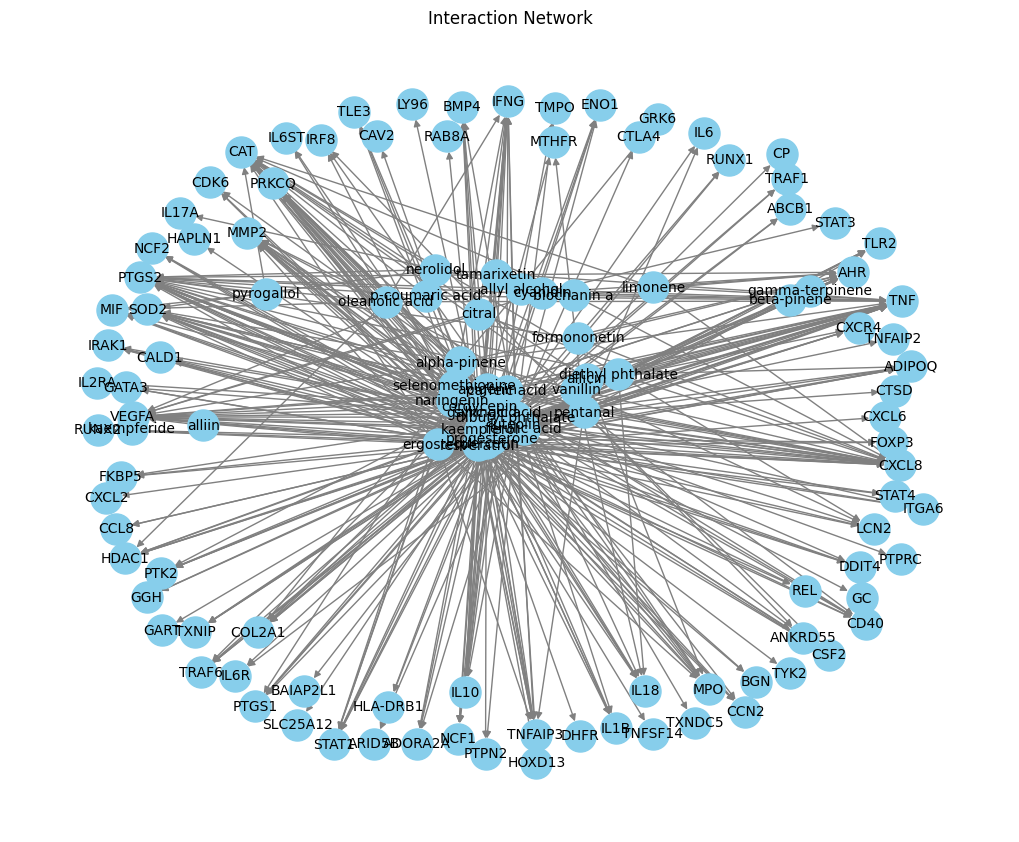

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges from 'target' to 'chemical'
for _, row in df_net.iterrows():
    G.add_edge(row['File Name'], row['Target Gene Symbol'])

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Position nodes using the Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, edge_color='gray', arrows=True)
plt.title('Interaction Network')
plt.show()

In [29]:
import networkx as nx

# Degree Distribution
degree = dict(G.degree())
print("Degree distribution:", degree)

# Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)

# Clustering Coefficient
clustering_coefficient = nx.average_clustering(G)
print("Clustering Coefficient:", clustering_coefficient)

Degree distribution: {'kaempferide': 1, 'VEGFA': 19, 'kaempferol': 19, 'ADIPOQ': 6, 'BMP4': 5, 'AHR': 17, 'CAT': 25, 'CSF2': 5, 'CXCL8': 21, 'IFNG': 13, 'IL10': 9, 'MMP2': 13, 'TNFAIP3': 9, 'IL1B': 5, 'IRAK1': 5, 'STAT1': 7, 'TRAF6': 5, 'COL2A1': 6, 'PTGS2': 24, 'SOD2': 13, 'TNF': 26, 'luteolin': 13, 'CD40': 6, 'PTK2': 5, 'alpha-pinene': 10, 'GRK6': 1, 'CDK6': 3, 'TLE3': 3, 'beta-pinene': 1, 'p-coumaric acid': 4, 'caffeic acid': 8, 'MPO': 8, 'limonene': 4, 'naringenin': 10, 'PTGS1': 5, 'allicin': 3, 'alliin': 1, 'biochanin a': 5, 'formononetin': 3, 'gallic acid': 12, 'NCF1': 4, 'MTHFR': 2, 'pyrogallol': 3, 'MIF': 6, 'syringic acid': 5, 'vanillin': 6, 'IL18': 7, 'LCN2': 5, 'ferulic acid': 9, 'TLR2': 5, 'resveratrol': 61, 'ADORA2A': 4, 'REL': 2, 'CXCL2': 1, 'ABCB1': 2, 'TRAF1': 2, 'FKBP5': 3, 'CCL8': 2, 'CXCL6': 1, 'NCF2': 3, 'HDAC1': 6, 'GGH': 2, 'PRKCQ': 4, 'GATA3': 2, 'HOXD13': 2, 'FOXP3': 2, 'DHFR': 1, 'RUNX2': 3, 'IL2RA': 2, 'IL6ST': 2, 'IRF8': 3, 'CXCR4': 4, 'RAB8A': 1, 'STAT4': 2,